<font size="5">

# Multi-Grid measurements at LET 2022 - preparations

<font size="3">

> __Author:__ A. Backis
<br/>__Institute:__ University of Glasgow (UoG), European Spallation Source (ESS)
<br/>__Date:__ 6/10-2021

_Abstract:_
This notebook contains the data analysis used for the preparations leading up to the LET measurements with the Multi-Grid detector.

# Contents
    
* [1. Introduction](#INTRODUCTION)
    * [1.1 Packages](#PACKAGES)
    * [1.2 Parameters](#PARAMETERS)
* [2. Validation](#VALIDATION)
    * [2.1 Parsing](#PARSING)
    * [2.2 Clustering](#CLUSTERING)
* [3. Utgård](#UTGÅRD) 

# 1. Introduction<a class="anchor" id="INTRODUCTION"></a>

Notebook showing the preparations leading up to the LET measurements.

## 1.1 Packages<a class="anchor" id="PACKAGES"></a>

Import necessary packages.

In [1]:
# Autoload packages when doing an external change
%load_ext autoreload
%autoreload 2

# Activate matplotlib in interactive notebook mode
%matplotlib widget

# Ensure custom packages can be reached
import os
import sys
import json
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
print(module_path)
    
# Install extra packages
!{sys.executable} -m pip install python-pcapng

# General packages
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import plotly as py
import plotly.graph_objs as go
import matplotlib.patheffects as path_effects

# Custom packages
import file_handling.mg_vmm_read as mg_read
import file_handling.mg_vmm_cluster as mg_cluster
import file_handling.mg_vmm_manage as mg_manage
import plotting.mg_vmm_basic_plot as mg_plot
import plotting.mg_vmm_debug as mg_debug
import mbuty.libTerminal as ta

/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis


## 1.2 Parameters<a class="anchor" id="PARAMETERS"></a>

Define global parameters.

In [2]:
# Constants
MODERATOR_TO_SAMPLE_IN_M = 25
CSPEC_TYPE = 64
TIME_RESOLUTION = 11.36e-9 # seconds

# Paths to folders containing data
nb_path = os.getcwd()
TEST_FOLDER = nb_path + '/../data/test/'
STF_DATA_FOLDER = nb_path + '/../data/let_stf_data/'
UTGARD_DATA_FOLDER = nb_path + '/../data/let_utgard_data/'

Prepare JSON file defining detector configuration.

In [ ]:
configuration_dict = {'detector': 'MG_LET',
                      'columns': 2,
                      'grids_per_column': 51,
                      'rows_per_grid': 6,
                      'layers_per_grid': 16,
                      'voxel_pitch_x_in_mm': 22.5, 
                      'voxel_pitch_y_in_mm': 22.5, # This should be a bit more due to spacing between adjacent grids
                      'voxel_pitch_z_in_mm': 10,
                      'wire_asic': 0,
                      'grid_asic': 1,
                      'column_to_electronic': {0: {'Ring': 0, 'FEN': 1, 'Hybrid': 0},
                                               1: {'Ring': 0, 'FEN': 1, 'Hybrid': 1}}
                      }

Declare helper function to transfer data to data folder.

In [ ]:
def update_data(source_path, destination_path):
    transferData = ta.transferDataUtil()
    transferData.syncData(source_path, destination_path)

# 2. Validation<a class="anchor" id="VALIDATION"></a>

Here we are going to validate that the code is working as expected. Starting with the data parser and progressively moving towards the more advanced features.

## 2.1. Parsing<a class="anchor" id="PARSING"></a>

In [ ]:
# Parse test data
#df_freia_test = mg_read.read_vmm_data(TEST_FOLDER + 'freiatest.pcapng')
#df_let_test = mg_read.read_vmm_data(TEST_FOLDER + 'cspec_for_alex.pcapng')
df_cspec_for_alex_2 = mg_read.read_vmm_data(TEST_FOLDER + 'cspec_for_alex_2.pcapng')
#df_frapi_test_1 = mg_read.read_vmm_data(TEST_FOLDER + '20220224_161540_duration_s_5_run_2_00000.pcapng')

In [ ]:
# Plot some test data
mg_plot.plot_vmm_data(df_cspec_for_alex_2, 'df_cspec_for_alex_2')
mg_plot.plot_time_stamp(df_cspec_for_alex_2, (1 / (88.0525 * 1e6)), 'df_cspec_for_alex_2')
mg_plot.plot_fen_and_vmm(df_cspec_for_alex_2, 'df_cspec_for_alex_2')
mg_plot.plot_vmm_and_channel_events(df_cspec_for_alex_2, 'df_cspec_for_alex_2')

In [ ]:
mg_plot.plot_vmm_data(df_cspec_for_alex_2, 'cspec_for_alex_2')

## 2.2. Clustering<a class="anchor" id="CLUSTERING"></a>

In [ ]:
# Cluster test data
df_clusters_cspec_for_alex_2 = mg_cluster.cluster_vmm_data(df_cspec_for_alex_2)

In [ ]:
# Plot some test data
mg_plot.plot_vmm_and_channel(df_clusters_cspec_for_alex_2, 'cspec_for_alex_2')
mg_plot.plot_multiplicity(df_clusters_cspec_for_alex_2, 'cspec_for_alex_2')
mg_plot.plot_tof(df_clusters_cspec_for_alex_2, 'cspec_for_alex_2')
mg_plot.plot_3D_hist(df_clusters_cspec_for_alex_2, 'cspec_for_alex_2')

# 3. Utgård<a class="anchor" id="UTGÅRD"></a>

In [ ]:
# Define a standard filter to remove everything except neutron events
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 3, True],                  # Grid multiplicity
             'wadc': [800, np.inf, False],        # Wire charge
             'gadc': [800, np.inf, False],        # Grid charge
             'tof': [0, np.inf, False],           # Time-of-flight (seconds)
             'time': [0, np.inf, False],          # Time (seconds)   
             'gch_max': [0, 51, False],           # Grid channel, bottom=0 to top=51
             'gchs_adjacent': [0, 0, False],      # 0=some grids in cluster are not adjacent
             'same_fen': [0, 0, False],           # 0=some events in cluster are not from the same fen
             'same_ring': [0, 0, False]           # 0=some events in cluster are not from the same ring
             }               

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_143658_pkts100_test_changed_hybrid_test_14_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
mg_debug.plot_channel_histograms_large(df_run_0, file_name)
#mg_debug.plot_adc_histograms(df_run_0, file_name)
#mg_debug.plot_channel_vs_adc_2d_histograms(df_run_0, file_name)
#mg_debug.plot_time_stamp(df_run_0, TIME_RESOLUTION, file_name)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_144619_pkts100_A4H0V0_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_144653_pkts100_A4H0V1_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_144732_pkts100_A4H1V0_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_144759_pkts100_A4H1V1_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_144857_pkts100_A1H0V0_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_144918_pkts100_A1H0V1_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_145026_pkts100_A1H1V0_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_145058_pkts100_A1H1V1_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_145429_pkts100_A4H0V0V1_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, lower_threshold=250)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_160609_pkts100_A4H0V0V1_3_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, lower_threshold=200, higher_threshold=500)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_161246_pkts1000_A4H1V0V1_2_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, lower_threshold=2000, higher_threshold=4000)

In [ ]:
c

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_162045_pkts20000_S2S4_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, lower_threshold=2000, higher_threshold=4000)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_162321_pkts2000_S2S4_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, lower_threshold=2000, higher_threshold=4000)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_162928_pkts100_S4_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, lower_threshold=200, higher_threshold=500)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_163011_pkts100_S8_00000's
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, lower_threshold=200, higher_threshold=500)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_163043_pkts100_S5_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, lower_threshold=200, higher_threshold=500)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220325_164242_pkts100_S2_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)

# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, lower_threshold=200, higher_threshold=500)

In [ ]:
# Declare path to file of interest
file_name = '20220330_160405_pkts100_g0_00000'
folder_path = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_stf_data/'
file_path = folder_path + file_name + '.pcapng'
# Import  data
df_run = mg_read.read_vmm_data(file_path)
# Cluster data
df_clu = mg_cluster.cluster_vmm_data(df_run, time_window=2e-6)
# Plot raw data
mg_debug.plot_channel_histograms_large(df_run, file_name, print_text=True, lower_threshold=200, higher_threshold=1000)
mg_debug.plot_channel_vs_adc_2d_histograms_large(df_run, file_name, number_bins=50)
# Filter clusterered data
#df_clu = mg_manage.filter_data(df_clu, mg_filter)
# Plot clusters
#mg_debug.plot_coincidences(df_clu, file_name)
#mg_debug.plot_multiplicity(df_clu, file_name)
#mg_debug.plot_phs_wires_vs_grids(df_clu, file_name)
#mg_debug.plot_phs_wires_and_grids(df_clu, file_name)
#mg_debug.plot_delta_time(df_clu, file_name, number_bins=200)

In [ ]:
# Declare path to file of interest
folder_path = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_stf_data/'
file_path = folder_path + file_name + '.pcapng'
# Update data
#update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_names = ['20220328_180259_duration_s_7200_RColumnAllActivated_00000',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00001',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00002',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00003',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00004',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00005',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00006']
events = np.empty([len(file_names)], dtype='object')
clus = np.empty([len(file_names)], dtype='object')
for i, file_name in enumerate(file_names):
    print(file_name)
    print('Importing')
    file_path = local_data_folder + file_name + '.pcapng'
    df_run_0 = mg_read.read_vmm_data(file_path)
    print('Clustering')
    df_clu_0 = mg_cluster.cluster_vmm_data(df_run_0, time_window=2e-6)
    events[i] = df_run_0
    clus[i] = df_clu_0

df_run = events[0]
df_clu = clus[0]
for i, (df_temp, df_run) in enumerate(zip(clus[1:], events[1:])):
    print(i)
    df_run = df_run.append(df_run, ignore_index=True)
    df_clu = df_clu.append(df_temp, ignore_index=True)
              
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
file_name = '20220328_180259_duration_s_7200_RColumnAllActivated'
# Plot raw data
mg_debug.plot_channel_histograms_large(df_run, file_name, print_text=False, lower_threshold=100, higher_threshold=500)
mg_debug.plot_channel_vs_adc_2d_histograms_large(df_run, file_name, number_bins=50)
#mg_debug.plot_adc_histograms_large(df_run_0, file_name, number_bins=50)
# Filter clusterered data
df_clu = mg_manage.filter_data(df_clu, mg_filter)
# Plot clusters
mg_debug.plot_coincidences(df_clu, file_name)
mg_debug.plot_multiplicity(df_clu, file_name)
mg_debug.plot_phs_wires_vs_grids(df_clu, file_name)
mg_debug.plot_phs_wires_and_grids(df_clu, file_name)
mg_debug.plot_delta_time(df_clu, file_name, number_bins=200)

In [ ]:
# Declare paths to files of interest
folder_path = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_stf_data/'
file_name = '20220330_174304_duration_s_1800_stf_Unshielded'
number_files = 31
# Import data
df_raw = mg_manage.import_many_files(folder_path, file_name, number_files)
# Cluster data
df_clu = mg_cluster.cluster_vmm_data(df_raw, time_window=2e-6)
# Plot raw data
mg_debug.plot_channel_histograms_large(df_raw, file_name, print_text=False, lower_threshold=100, higher_threshold=500)
mg_debug.plot_channel_vs_adc_2d_histograms_large(df_raw, file_name, number_bins=50)
# Plot clusters
mg_debug.plot_coincidences(df_clu, file_name)
mg_debug.plot_multiplicity(df_clu, file_name)
mg_debug.plot_phs_wires_vs_grids(df_clu, file_name)
mg_debug.plot_phs_wires_and_grids(df_clu, file_name)
mg_debug.plot_delta_time(df_clu, file_name, number_bins=200)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
#update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_names = ['20220328_180259_duration_s_7200_RColumnAllActivated_00000',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00001',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00002',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00003',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00004',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00005',
              '20220328_180259_duration_s_7200_RColumnAllActivated_00006']
events = np.empty([len(file_names)], dtype='object')
clus = np.empty([len(file_names)], dtype='object')
for i, file_name in enumerate(file_names):
    print(file_name)
    print('Importing')
    file_path = local_data_folder + file_name + '.pcapng'
    df_run_0 = mg_read.read_vmm_data(file_path)
    print('Clustering')
    df_clu_0 = mg_cluster.cluster_vmm_data(df_run_0, time_window=2e-6)
    events[i] = df_run_0
    clus[i] = df_clu_0

df_run = events[0]
df_clu = clus[0]
for i, (df_temp, df_run) in enumerate(zip(clus[1:], events[1:])):
    print(i)
    df_run = df_run.append(df_run, ignore_index=True)
    df_clu = df_clu.append(df_temp, ignore_index=True)
              
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
file_name = '20220328_180259_duration_s_7200_RColumnAllActivated'
# Plot raw data
mg_debug.plot_channel_histograms_large(df_run, file_name, print_text=False, lower_threshold=100, higher_threshold=500)
mg_debug.plot_channel_vs_adc_2d_histograms_large(df_run, file_name, number_bins=50)
#mg_debug.plot_adc_histograms_large(df_run_0, file_name, number_bins=50)
# Filter clusterered data
df_clu = mg_manage.filter_data(df_clu, mg_filter)
# Plot clusters
mg_debug.plot_coincidences(df_clu, file_name)
mg_debug.plot_multiplicity(df_clu, file_name)
mg_debug.plot_phs_wires_vs_grids(df_clu, file_name)
mg_debug.plot_phs_wires_and_grids(df_clu, file_name)
mg_debug.plot_delta_time(df_clu, file_name, number_bins=200)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220328_180259_duration_s_7200_RColumnAllActivated_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot raw data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, print_text=False, lower_threshold=100, higher_threshold=500)
mg_debug.plot_channel_vs_adc_2d_histograms_large(df_run_0, file_name, number_bins=50)
#mg_debug.plot_adc_histograms_large(df_run_0, file_name, number_bins=50)
# Cluster data
df_clu_0 = mg_cluster.cluster_vmm_data(df_run_0, time_window=0.5e-6)
# Plot clusters
mg_debug.plot_coincidences(df_clu_0, file_name)
mg_debug.plot_multiplicity(df_clu_0, file_name)
mg_debug.plot_phs_wires_vs_grids(df_clu_0, file_name)
mg_debug.plot_phs_wires_and_grids(df_clu_0, file_name)
mg_debug.plot_delta_time(df_clu_0, file_name, number_bins=200)
#mg_debug.plot_time(df_clu_0, file_name)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220328_095624_pkts100_S2_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, print_text=False, lower_threshold=100, higher_threshold=500)
mg_debug.plot_adc_histograms_large(df_run_0, file_name, number_bins=100)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220328_095724_pkts100_S2_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, print_text=False, lower_threshold=100, higher_threshold=500)
mg_debug.plot_adc_histograms_large(df_run_0, file_name, number_bins=100)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
#update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220328_095752_pkts100_S4_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, print_text=False, lower_threshold=100, higher_threshold=500)
mg_debug.plot_adc_histograms_large(df_run_0, file_name, number_bins=100)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
#update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220328_095838_pkts100_S8_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, print_text=True, lower_threshold=100, higher_threshold=500)
mg_debug.plot_adc_histograms_large(df_run_0, file_name, number_bins=100)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220328_095859_pkts100_S5_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, print_text=False, lower_threshold=100, higher_threshold=500)
mg_debug.plot_adc_histograms_large(df_run_0, file_name, number_bins=100)

In [ ]:
# Define data paths
remote_data_folder = 'essdaq@172.30.244.19:~/let_utgard_data/'
local_data_folder = '/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/data/let_utgard_data/'
# Update data
update_data(remote_data_folder, local_data_folder)
# Declare path to file of interest
file_name = '20220328_095943_size_kb_20000_AllOn_data_00000'
file_path = local_data_folder + file_name + '.pcapng'
# Import  data
df_run_0 = mg_read.read_vmm_data(file_path)
# Plot data
mg_debug.plot_channel_histograms_large(df_run_0, file_name, print_text=False, lower_threshold=100, higher_threshold=500)
mg_debug.plot_adc_histograms_large(df_run_0, file_name, number_bins=100)

# 4. STF<a class="anchor" id="STF"></a>

Declare filter.

In [5]:
mg_filter = {'wm': [1, 1, True],                  # Wire multiplicity
             'gm': [1, 3, True],                  # Grid multiplicity
             'wadc': [800, np.inf, False],        # Wire charge
             'gadc': [800, np.inf, False],        # Grid charge
             'tof': [0, np.inf, False],           # Time-of-flight (seconds)
             'time': [0, np.inf, False],          # Time (seconds)   
             'gch_max': [0, 51, False],           # Grid channel, bottom=0 to top=51
             'gchs_adjacent': [0, 0, False],      # 0=some grids in cluster are not adjacent
             'same_fen': [0, 0, False],           # 0=some events in cluster are not from the same fen
             'same_ring': [0, 0, False]           # 0=some events in cluster are not from the same ring
             }     

Plot one data set

/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/plotting/mg_vmm_debug.py:279: RuntimeWarning: invalid value encountered in double_scalars
  print('Duration', duration, 'seconds')
/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/plotting/mg_vmm_debug.py:280: RuntimeWarning: invalid value encountered in double_scalars
  rate_per_s_1 = df_1.shape[0] / duration
/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/plotting/mg_vmm_debug.py:281: RuntimeWarning: divide by zero encountered in double_scalars
  rate_per_m_s_1 = (df_1.shape[0] / duration) / area
/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/plotting/mg_vmm_debug.py:282: RuntimeWarning: divide by zero encountered in double_scalars
  rate_per_s_2 = df_2.shape[0] / duration
/Users/alexanderbackis/Documents/code/mg-let-2022-vmm-analysis/plotting/mg_vmm_debug.py:400: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.hist(df_column.gadc, bins=number

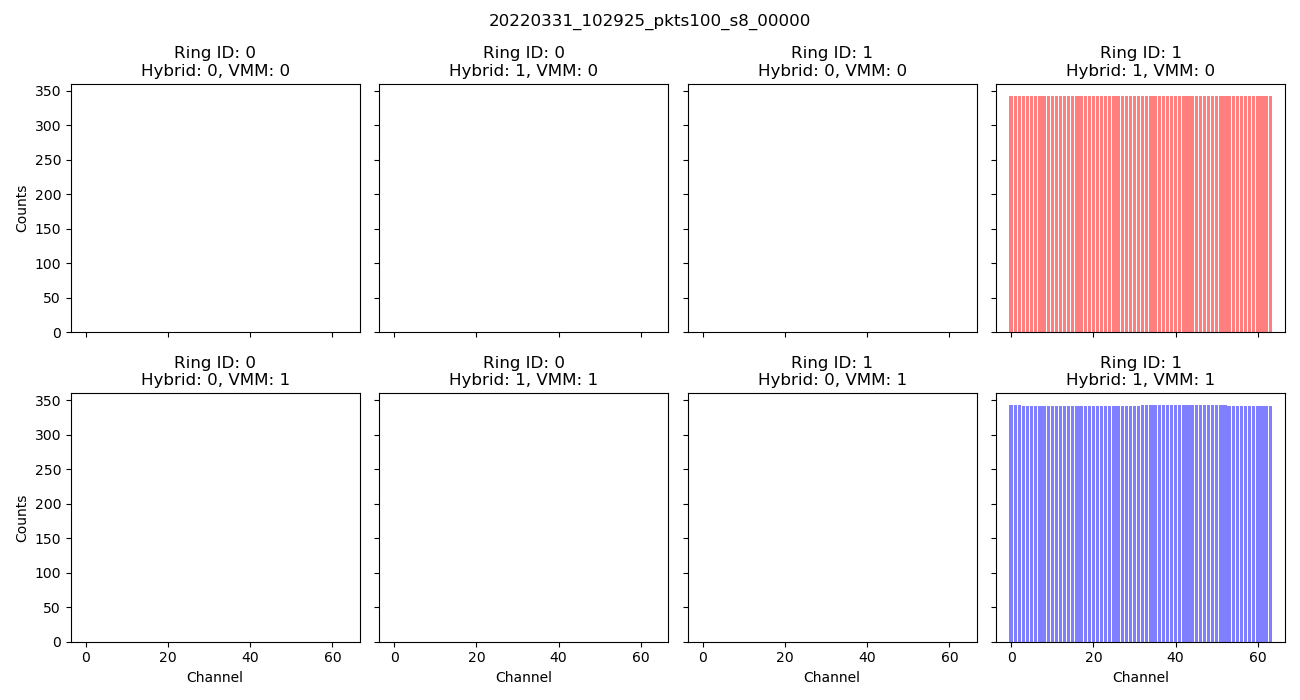

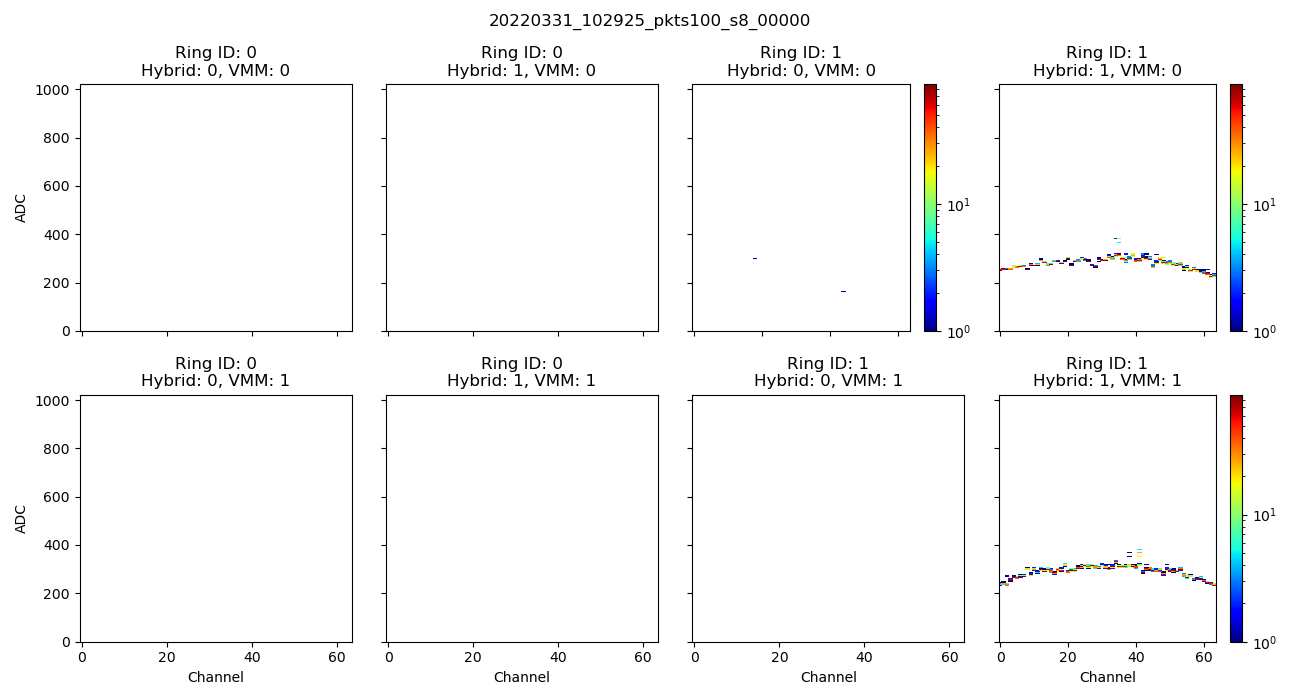

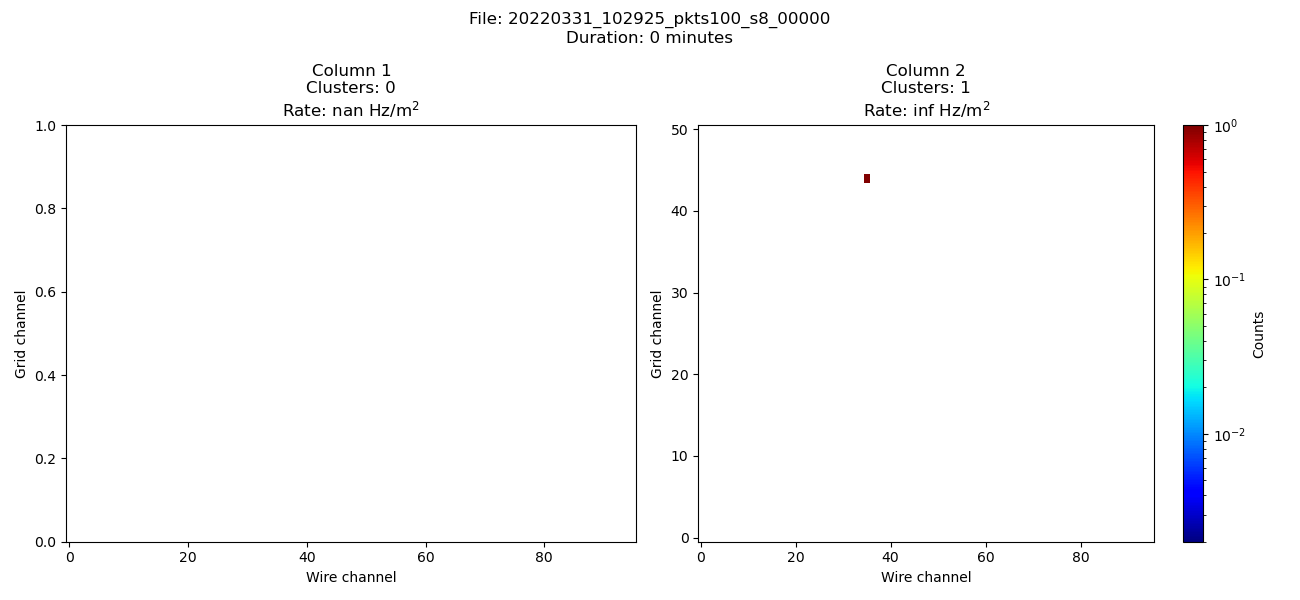

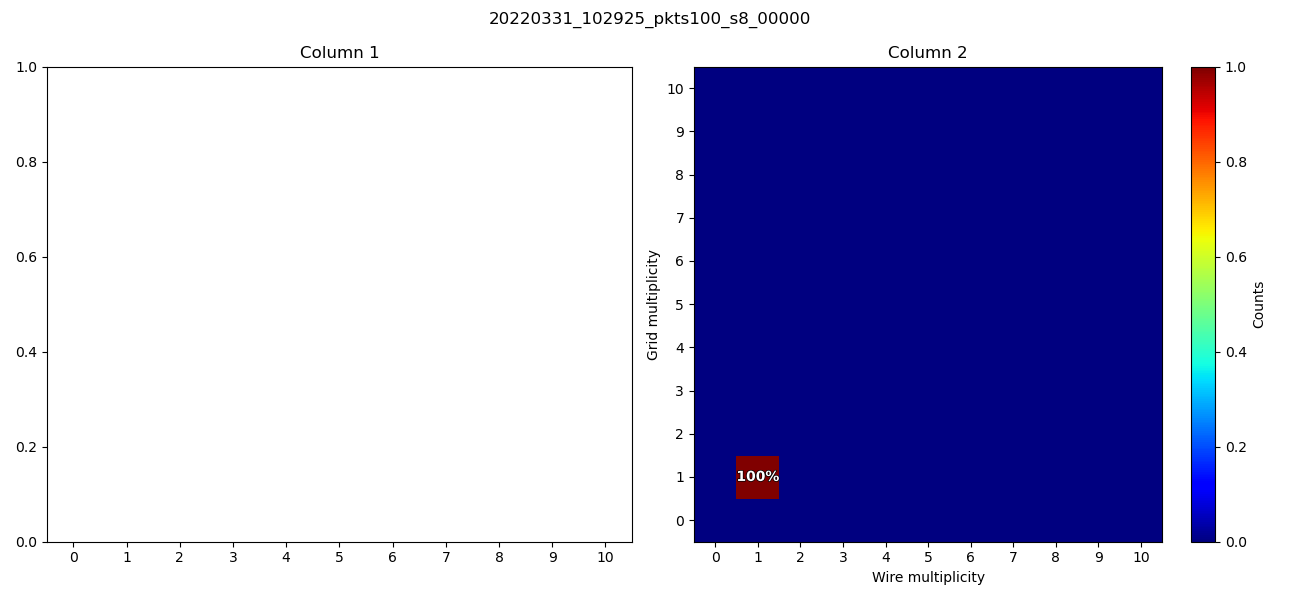

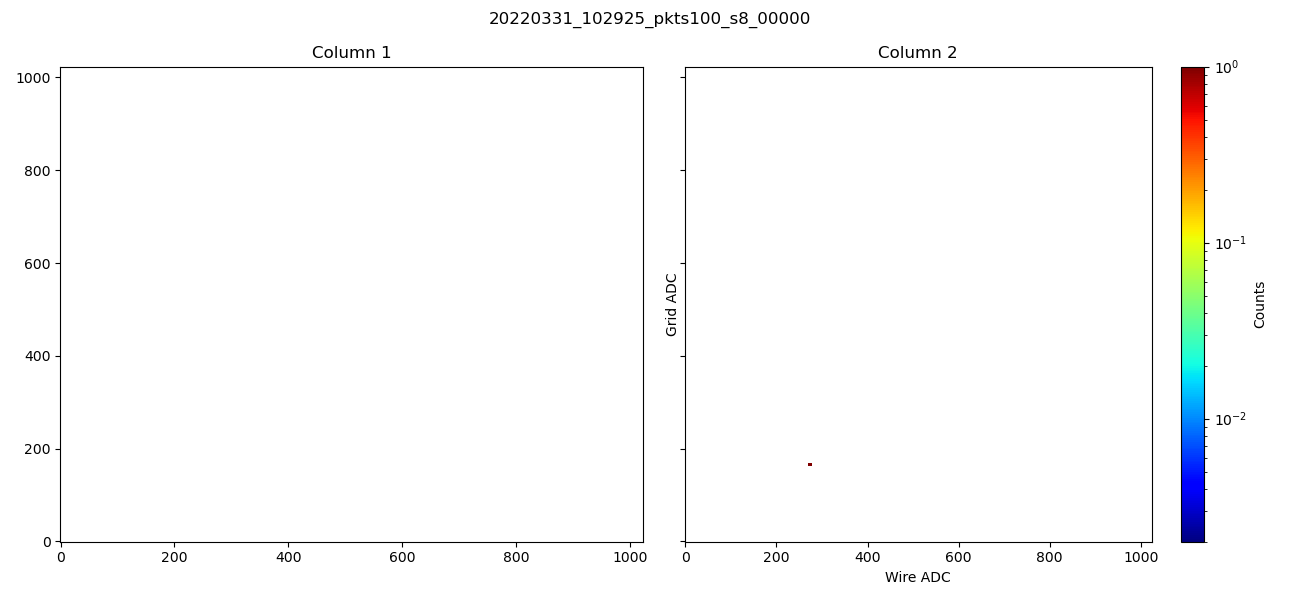

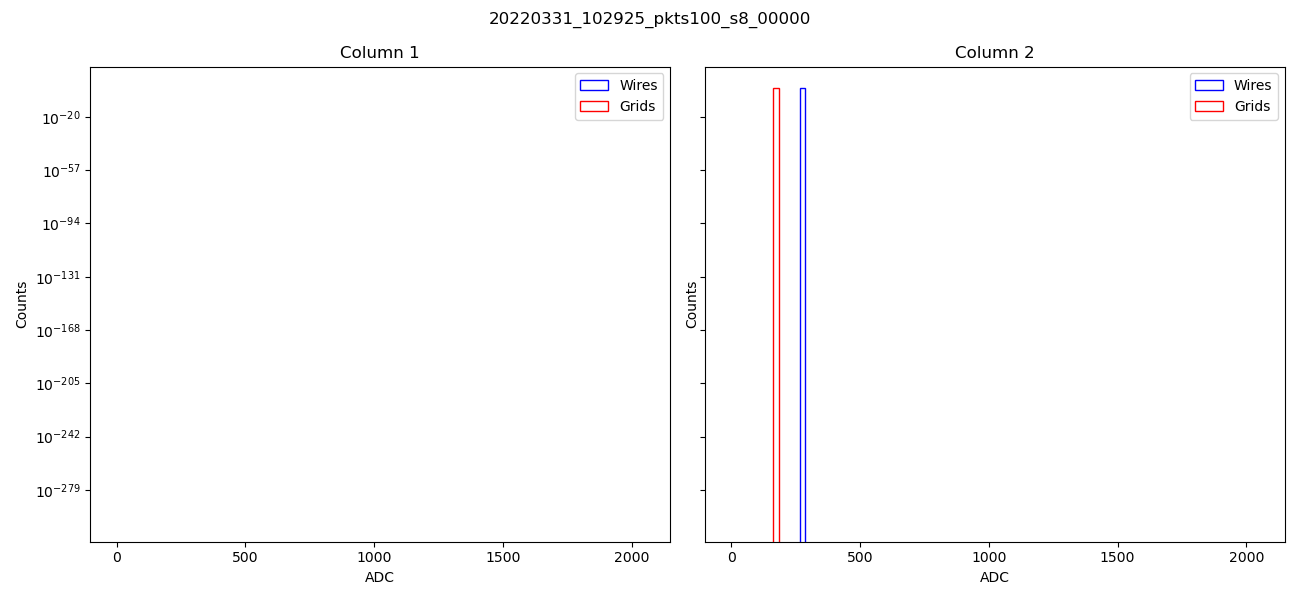

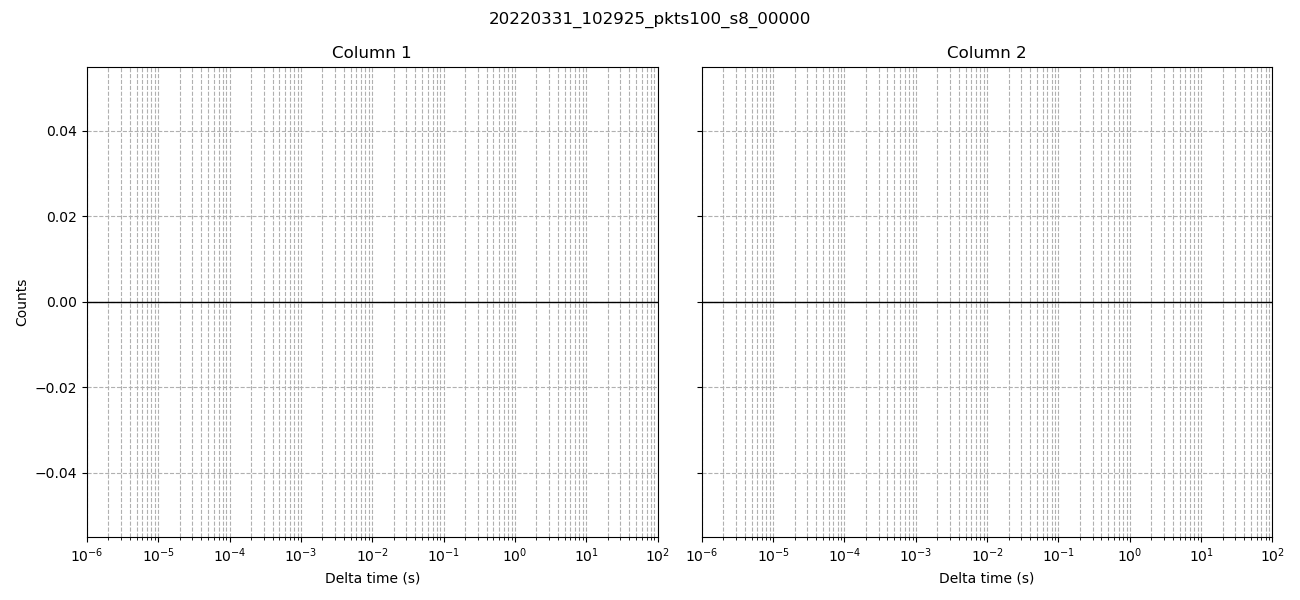

In [8]:
# Declare path to file of interest
folder_path = STF_DATA_FOLDER
file_name = '20220331_102925_pkts100_s8_00000'
file_path = folder_path + file_name + '.pcapng'
# Import  data
df_run = mg_read.read_vmm_data(file_path)
# Cluster data
df_clu = mg_cluster.cluster_vmm_data(df_run, time_window=2e-6)
# Plot raw data
mg_debug.plot_channel_histograms_large(df_run, file_name, print_text=False, lower_threshold=200, higher_threshold=1000)
mg_debug.plot_channel_vs_adc_2d_histograms_large(df_run, file_name, number_bins=50)
# Filter clusterered data
df_clu = mg_manage.filter_data(df_clu, mg_filter)
# Plot clusters
mg_debug.plot_coincidences(df_clu, file_name)
mg_debug.plot_multiplicity(df_clu, file_name)
mg_debug.plot_phs_wires_vs_grids(df_clu, file_name)
mg_debug.plot_phs_wires_and_grids(df_clu, file_name)
mg_debug.plot_delta_time(df_clu, file_name, number_bins=200)

Plot several data sets

In [ ]:
# Declare paths to files of interest
folder_path = STF_DATA_FOLDER
file_name = '20220330_174304_duration_s_1800_stf_Unshielded'
number_files = 31
# Import data
df_raw = mg_manage.import_many_files(folder_path, file_name, number_files)
# Cluster data
df_clu = mg_cluster.cluster_vmm_data(df_raw, time_window=2e-6)
# Plot raw data
mg_debug.plot_channel_histograms_large(df_raw, file_name, print_text=False, lower_threshold=100, higher_threshold=500)
mg_debug.plot_channel_vs_adc_2d_histograms_large(df_raw, file_name, number_bins=50)
# Plot clusters
mg_debug.plot_coincidences(df_clu, file_name)
mg_debug.plot_multiplicity(df_clu, file_name)
mg_debug.plot_phs_wires_vs_grids(df_clu, file_name)
mg_debug.plot_phs_wires_and_grids(df_clu, file_name)
mg_debug.plot_delta_time(df_clu, file_name, number_bins=200)